# Data Conversion and Aggregation for Alchemlyb


## Overview
HDF5 seems a trivial answer for data conversion but there are other options we can explore such as Apache Arrow and Python Pickle. I/O performance optimization for parallel file system can start with avoiding bottlenecks created by applications and ensure best practice in achieving maximum IOPS, bandwidth and low latency. This ipython notebook explains data conversion and aggregation with a HDF5 format provided by PyTables, *HDFStore* as a process of reducing I/O operations and gaining speed-up on data retrieval.

## Background
We read *N* number (>10k) of ascii files independently (which means single file stream) to parse content and convert them to a new data format (optional). The file sizes are small (less than 1GB, typically 1-30MB) in which parallel file system doesn't perform well. This is because of metadata servers in distributed storage architecture which is responsible for data placement in multiple locations and the cost of managing namespace and inode of files is high for this case, small files with no multiple access from clients on a shared filesystem. The extra cost will become less significant as a file size is increased and a number of files to open is reduced. This concludes constructing a master file for aggregating data from multiple files may help reduce processing time.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
df = pd.read_csv(open("conversion_benchmark.txt"), sep=",",quotechar = '\'', header=None, names=['type','size','format','elapsed_time','start_time','end_time'])
#convert,1048656,hdf,0.30823349952697754,1556276066.5880184,1556276066.279785

### Conversion Benchmark (Write)

This section shows benchmark results among different file formats between 1MB to 1GB data sizes. HDF and feather (Arrow python API) shows competitive performance in the subsequent plot. stata, json and csv perform worse as size increases.

A full list of file formats supported by Pandas: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#serialization-io-conversion

Text(0,0.5,u'Elapsed Time (s)')

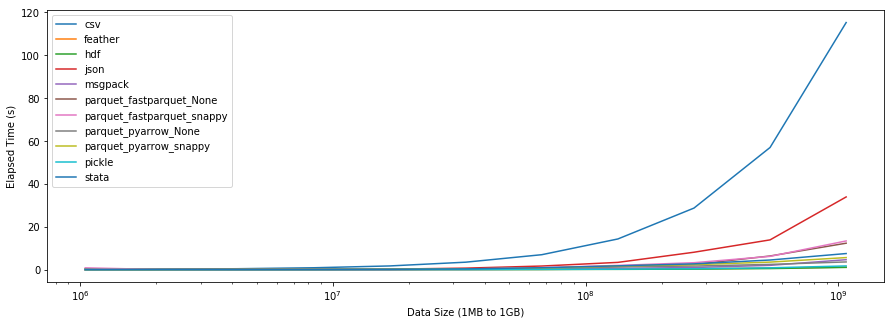

In [105]:
fig, ax = plt.subplots(figsize=(15,5))
xtick_names = ["{}MB".format(name / 2**20) for name, group in df.groupby('size')]
ax.set_xticks([2**20*(2**size) for size in range(0,11)])
ax.set_xticklabels(xtick_names)

for name, group in df[df.type=='convert'].groupby(['format']):
    #print (name,group)
    group.plot(x='size', y='elapsed_time',ax=ax, label=name, logx=True)
ax.set_xlabel('Data Size (1MB to 1GB)')
ax.set_ylabel('Elapsed Time (s)')

### Conversion (Write) - stat, json, csv removed

Text(0,0.5,u'Elapsed Time (s)')

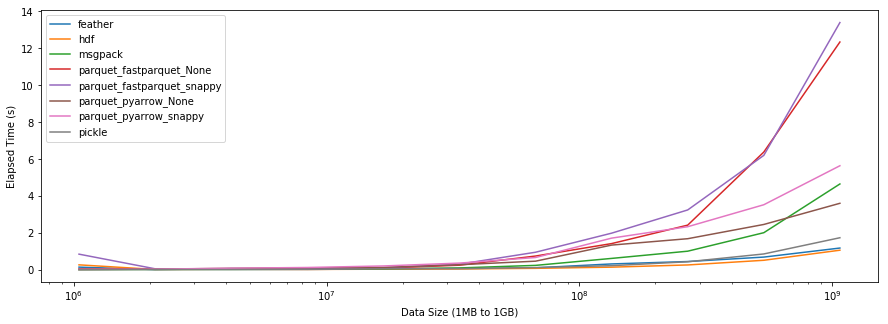

In [107]:
fig, ax = plt.subplots(figsize=(15,5))
xtick_names = ["{}MB".format(name / 2**20) for name, group in df.groupby('size')]
ax.set_xticks([2**20*(2**size) for size in range(0,11)])
ax.set_xticklabels(xtick_names)
for name, group in df[(df.type=='convert') & (df.format != 'stata') & (df.format != 'json') & (df.format != 'csv')].groupby(['format']):
    #print (name,group)
    group.plot(x='size', y='elapsed_time',ax=ax, label=name, logx=True)
ax.set_xlabel('Data Size (1MB to 1GB)')
ax.set_ylabel('Elapsed Time (s)')

## Conversion (Read)

Same benchmark results but for reading files. Json format perform worse as data size increases. Parquet with snappy and hdf show competitive results for reading in the subsequent plot.

Text(0,0.5,u'Elapsed Time (s)')

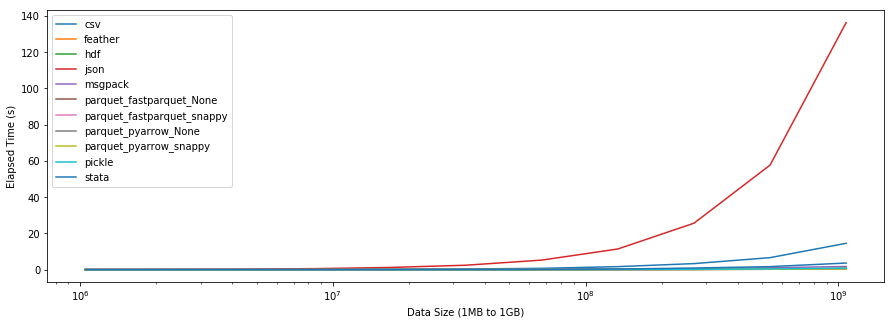

In [108]:
fig, ax = plt.subplots(figsize=(15,5))
xtick_names = ["{}MB".format(name / 2**20) for name, group in df.groupby('size')]
ax.set_xticks([2**20*(2**size) for size in range(0,11)])
ax.set_xticklabels(xtick_names)
for name, group in df[df.type=='load'].groupby(['format']):
    #print (name,group)
    group.plot(x='size', y='elapsed_time',ax=ax, label=name, logx=True)
ax.set_xlabel('Data Size (1MB to 1GB)')
ax.set_ylabel('Elapsed Time (s)')    

### Conversion (Read) - json, csv, stata, msgpack removed

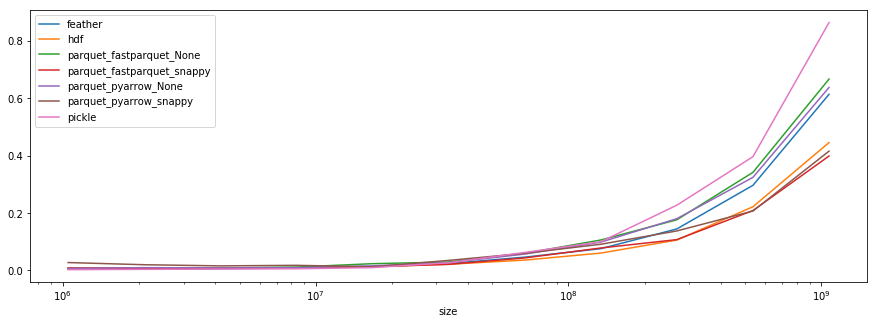

In [99]:
fig, ax = plt.subplots(figsize=(15,5))
xtick_names = ["{}MB".format(name / 2**20) for name, group in df.groupby('size')]
ax.set_xticks([2**20*(2**size) for size in range(0,11)])
ax.set_xticklabels(xtick_names)
for name, group in df[(df.type=='load') & (df.format != 'json') & (df.format != 'csv') & (df.format != 'stata') & (df.format != 'msgpack') ].groupby(['format']):
    #print (name,group)
    group.plot(x='size', y='elapsed_time',ax=ax, label=name, logx=True)

## Discussion
Data corruption of a hdf format needs to be addressed since it's a binary format and complicated to repair. For example, instead of keeping a single master h5 file, creating partitioned h5 files may reduce recovery impacts. Also, we intend to keep the original data files i.e. GROMACS xvg files, therefore it's possible to restore a corrupted h5 file from the original.

The prototype is tested with GROMACS xvg files but ohter tools e.g. AMBER, NAMD are equally applicable.